## This is the svm workbook for ECE 239AS Assignment #2

Please follow the notebook linearly to implement a linear support vector machine.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and includes code to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training an SVM classifier via gradient descent.

## Importing libraries and data setup

In [1]:
import numpy as np # for doing most of our calculations
import matplotlib.pyplot as plt# for plotting
from cs231n.data_utils import load_CIFAR10 # function to load the CIFAR-10 dataset.
import pdb

# Load matplotlib images inline
%matplotlib inline

# These are important for reloading any code you write in external .py files.
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Set the path to the CIFAR-10 data
cifar10_dir = 'cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


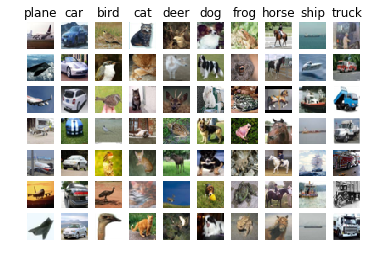

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Dev data shape: ', X_dev.shape)
print('Dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
Dev data shape:  (500, 32, 32, 3)
Dev labels shape:  (500,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


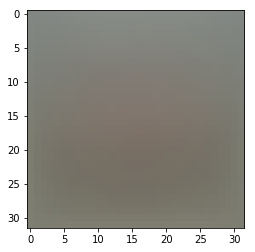

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## Question:

(1) For the SVM, we perform mean-subtraction on the data.
However, for the KNN notebook, we did not.
Why?

## Answer:

(1) You fill this out.

Because for SVM we'd like to perform mean-subtraction so that each feature has a similar range. Thus the gradient will not go out of control.


## Training an SVM

The following cells will take you through building an SVM.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [9]:
from nndl.svm import SVM

In [10]:
# Declare an instance of the SVM class.  
# Weights are initialized to a random value.
# Note, to keep people's initial solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

svm = SVM(dims=[num_classes, num_features])

#### SVM loss

In [11]:
## Implement the loss function for in the SVM class(nndl/svm.py), svm.loss()

loss = svm.loss(X_train, y_train)
print('The training set loss is {}.'.format(loss))

# If you implemented the loss correctly, it should be 15569.98

The training set loss is 15569.977915410187.


#### SVM gradient

In [12]:
## Calculate the gradient of the SVM class.
# For convenience, we'll write one function that computes the loss
#   and gradient together. Please modify svm.loss_and_grad(X, y).
# You may copy and paste your loss code from svm.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

num_classes = len(np.unique(y_dev))
num_features = X_dev.shape[1]

svm = SVM(dims=[num_classes, num_features])
loss, grad = svm.fast_loss_and_grad(X_dev,y_dev)

# Compare your gradient to a numerical gradient check. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
svm.grad_check_sparse(X_dev, y_dev, grad)

numerical: 2.156444 analytic: 2.156444, relative error: 2.570943e-08
numerical: 8.011034 analytic: 8.011034, relative error: 8.381657e-09
numerical: -12.274274 analytic: -12.274276, relative error: 4.948802e-08
numerical: 6.230246 analytic: 6.230247, relative error: 3.681040e-08
numerical: 3.460897 analytic: 3.460897, relative error: 7.375932e-08
numerical: 4.434671 analytic: 4.434671, relative error: 2.942327e-08
numerical: -6.706129 analytic: -6.706130, relative error: 5.247472e-08
numerical: -1.940658 analytic: -1.940658, relative error: 1.587818e-07
numerical: -2.941114 analytic: -2.941113, relative error: 7.743607e-08
numerical: -3.430537 analytic: -3.430537, relative error: 3.129144e-08


## A vectorized version of SVM

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [13]:
import time

In [14]:
## Implement svm.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = svm.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = svm.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} / {}'.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output, i.e., differences on the order of 1e-12

Normal loss / grad_norm: 17970.48263115651 / 2212.122863348999 computed in 0.04653191566467285s
Vectorized loss / grad: 17970.482631156476 / 2212.122863348999 computed in 0.008005619049072266s
difference in loss / grad: 3.2741809263825417e-11 / 3.1873552196603847e-12


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

iteration 0 / 1500: loss 13974.14456463232
iteration 100 / 1500: loss 5315.058920843041
iteration 200 / 1500: loss 3852.380230966631
iteration 300 / 1500: loss 3601.585221827434
iteration 400 / 1500: loss 3002.2006053425393
iteration 500 / 1500: loss 3067.8300081114517
iteration 600 / 1500: loss 2976.246669503134
iteration 700 / 1500: loss 2848.0507060170175
iteration 800 / 1500: loss 2504.7955866992997
iteration 900 / 1500: loss 2054.6782309359205
iteration 1000 / 1500: loss 2247.459704603464
iteration 1100 / 1500: loss 1982.09177327336
iteration 1200 / 1500: loss 2306.1380338022223
iteration 1300 / 1500: loss 2040.89161542307
iteration 1400 / 1500: loss 1572.4562872586353
That took 9.940029859542847s


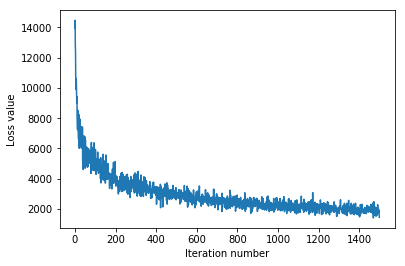

In [15]:
# Implement svm.train() by filling in the code to extract a batch of data
# and perform the gradient step.

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

svm = SVM(dims=[num_classes, num_features])


tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=5e-4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained SVM on the validation data.

In [16]:
## Implement svm.predict() and use it to compute the training and testing error.

y_train_pred = svm.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = svm.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.2881224489795918
validation accuracy: 0.292


## Optimize the SVM

Note, to make things faster and simpler, we won't do k-fold cross-validation, but will only optimize the hyperparameters on the validation dataset (X_val, y_val).

iteration 0 / 1500: loss 17495.34351582195
iteration 100 / 1500: loss 3700.8779915662367
iteration 200 / 1500: loss 3658.4190995692134
iteration 300 / 1500: loss 3196.355773612913
iteration 400 / 1500: loss 2758.887280019843
iteration 500 / 1500: loss 2997.3043518534187
iteration 600 / 1500: loss 2900.9026669039963
iteration 700 / 1500: loss 2344.6551809568714
iteration 800 / 1500: loss 2408.1723811276793
iteration 900 / 1500: loss 2630.5476964861095
iteration 1000 / 1500: loss 1968.6165481453684
iteration 1100 / 1500: loss 2401.0609042862793
iteration 1200 / 1500: loss 2671.1509478954213
iteration 1300 / 1500: loss 2016.8471796668819
iteration 1400 / 1500: loss 1516.202362523913
training accuracy: 0.31689795918367347
validation accuracy: 0.312
test accuracy: 0.307


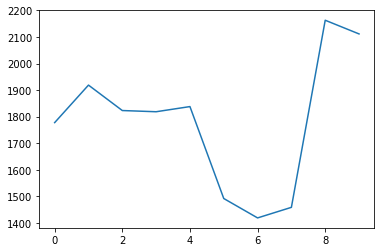

In [41]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the SVM with different learning rates and evaluate on the
#     validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best VALIDATION accuracy corresponding to the best VALIDATION error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
#   Note: You do not need to modify SVM class for this section
# ================================================================ #

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

svm = SVM(dims=[num_classes, num_features])
loss_out = []
for i in range(10):
    learning_rate = 5e-4+i*1e-4

    num_classes = len(np.unique(y_train))
    num_features = X_train.shape[1]

    svm = SVM(dims=[num_classes, num_features])
    
    loss_array = svm.train(X_train, y_train, learning_rate=learning_rate,
                      num_iters=1500, verbose=False)
    loss_out.append(loss_array[-1])


best_learning_rate = 5e-4+loss_out.index(min(loss_out))*1e-4
num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]
svm = SVM(dims=[num_classes, num_features])
loss_array = svm.train(X_train, y_train, learning_rate=best_learning_rate,
                      num_iters=1500, verbose=True)
plt.plot(np.arange(10),loss_out)
y_train_pred = svm.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = svm.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))
y_test_pred = svm.predict(X_test)
print('test accuracy: {}'.format(np.mean(np.equal(y_test, y_test_pred)), ))
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


In [42]:
best_learning_rate

0.0011

In [57]:
best_learning_rate = 0.0011
num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]
svm = SVM(dims=[num_classes, num_features])
loss_array = svm.train(X_train, y_train, learning_rate=best_learning_rate,
                      num_iters=1500, verbose=True)
y_train_pred = svm.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = svm.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))
y_test_pred = svm.predict(X_test)
print('test accuracy: {}'.format(np.mean(np.equal(y_test, y_test_pred)), ))

iteration 0 / 1500: loss 18764.600285176606
iteration 100 / 1500: loss 3966.2065132645353
iteration 200 / 1500: loss 3018.4382459460326
iteration 300 / 1500: loss 2964.118813166855
iteration 400 / 1500: loss 3218.040024669188
iteration 500 / 1500: loss 2373.253582839996
iteration 600 / 1500: loss 2537.887373478545
iteration 700 / 1500: loss 1886.2829877897238
iteration 800 / 1500: loss 1754.8359762520447
iteration 900 / 1500: loss 2342.922767689964
iteration 1000 / 1500: loss 2084.3168196720094
iteration 1100 / 1500: loss 1972.5757776925564
iteration 1200 / 1500: loss 2366.70788514614
iteration 1300 / 1500: loss 2087.060756899335
iteration 1400 / 1500: loss 2228.7489417450797
training accuracy: 0.3283877551020408
validation accuracy: 0.325
test accuracy: 0.314


In [67]:
best_learning_rate = 0.0011
num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]
svm = SVM(dims=[num_classes, num_features])
loss_array = svm.train(X_train, y_train, learning_rate=best_learning_rate,
                      num_iters=1500, verbose=True)
y_train_pred = svm.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = svm.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))
y_test_pred = svm.predict(X_test)
print('test accuracy: {}'.format(np.mean(np.equal(y_test, y_test_pred)), ))

iteration 0 / 1500: loss 15137.335603892561
iteration 100 / 1500: loss 4125.888340831784
iteration 200 / 1500: loss 3790.4825765154324
iteration 300 / 1500: loss 3200.2072165677296
iteration 400 / 1500: loss 2352.704145562654
iteration 500 / 1500: loss 2511.1011153829
iteration 600 / 1500: loss 2833.025529064627
iteration 700 / 1500: loss 2020.4789609436389
iteration 800 / 1500: loss 2507.87760094664
iteration 900 / 1500: loss 1766.4295429869505
iteration 1000 / 1500: loss 2513.6717023281813
iteration 1100 / 1500: loss 1952.2699913281642
iteration 1200 / 1500: loss 2595.3182852743794
iteration 1300 / 1500: loss 2320.480509638853
iteration 1400 / 1500: loss 2071.1168593708444
training accuracy: 0.32073469387755105
validation accuracy: 0.321
test accuracy: 0.304


#### The result of the same learning rate may perform differently.